Given a graph find the max cut of two different colored nodes in the graph.

Approach : 
- Create problem hamiltonian and mixer hamiltonian. 
- run cobyla minimizer along with parameters. 

Author : Vadhri venkata ratnam

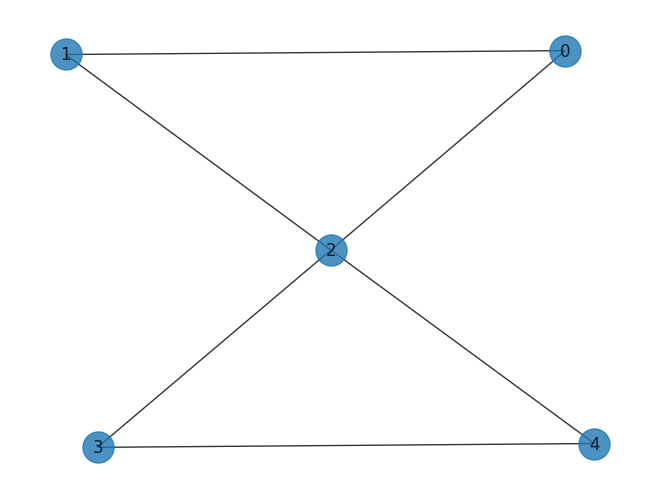

In [221]:
import networkx as nx
from qiskit import *
from qiskit.circuit import Parameter

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3,4])
graph.add_edges_from([(0,2), (1, 2), (2, 3), (2,4), (0,1), (3,4)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

### Gamma circuit; Problem hamiltonian.


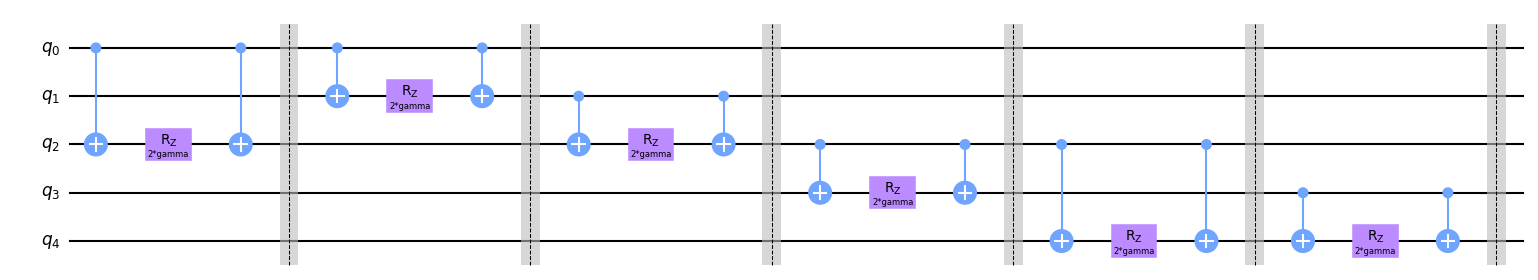

In [222]:
qc_gamma = QuantumCircuit(5)
gamma = Parameter('gamma')

for s,e in graph.edges():
    qc_gamma.cx(s,e)
    qc_gamma.rz(2*gamma, e)
    qc_gamma.cx(s,e)
    qc_gamma.barrier()

qc_gamma.draw(fold=1000, output="mpl", scale=0.75)


### Mixer hamiltonian

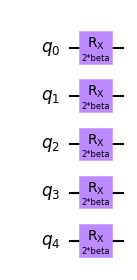

In [223]:
qc_mixer = QuantumCircuit(5)
beta = Parameter('beta')

for i in range(5):
    qc_mixer.rx(2*beta, i)

qc_mixer.draw(fold=1000, output="mpl", scale=0.75)



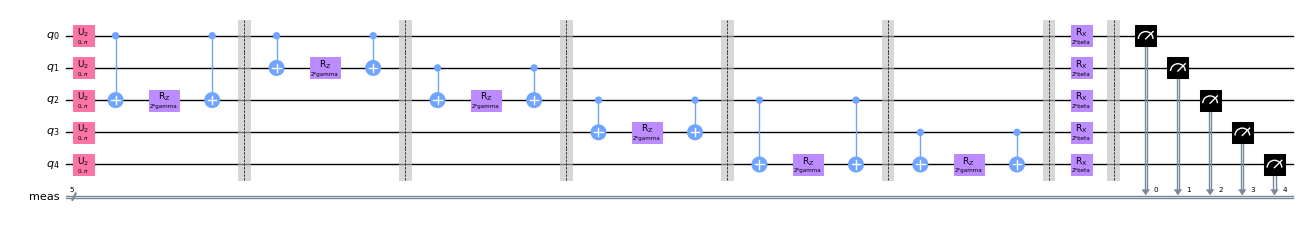

In [224]:
QC = QuantumCircuit(5)

for i in range(5):
    QC.h(i)

QC.append(qc_gamma, [0,1,2,3,4])
QC.append(qc_mixer, [0,1,2,3,4])

QC.measure_all()
QC = QC.decompose()

tqc = transpile(QC, backend=Aer.get_backend('aer_simulator'))

QC.draw(output="mpl", scale=0.5, fold=1000)


The objective of the function below is to take a specific solution and revert its solution to negative number to rhyme with the minimizer. 

In [225]:
def maxcut_obj(solution, graph):
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [226]:
def quantum_circuit(graph):
    backend=Aer.get_backend('aer_simulator')

    def circuit_run(parameters):
        g, b = parameters
        a = assemble(tqc, backend=backend, shots=1,parameter_binds=[{beta: b, gamma: g}])
        counts = backend.run(a, shots=1000).result().get_counts() 
        return compute_expectation(counts, graph)
    return circuit_run

/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_22604/2149072633.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  counts = backend.run(a, shots=1000).result().get_counts()


progress [2. 1.]
progress [2. 2.]
progress [2.63264362 0.22555694]
progress [3.58499404 0.53056297]
progress [ 2.31643783 -0.16175933]
progress [2.47056478 0.41589992]
progress [2.86743161 0.13968145]
progress [2.58806559 0.10877596]
progress [2.69513035 0.22684494]
progress [2.75309928 0.25020845]
progress [2.80766713 0.21973551]
progress [2.78357221 0.3047763 ]
progress [2.81404515 0.35934414]
progress [2.82403523 0.42104057]
progress [2.87008238 0.33166601]
progress [2.88874555 0.35673089]
progress [2.91424303 0.37479857]
progress [2.86437966 0.37629785]
progress [2.90315325 0.35068451]
progress [2.88327094 0.36230438]
progress [2.88373604 0.3507359 ]
progress [2.89243651 0.35800981]
progress [2.88791686 0.35496229]
progress [2.88798416 0.3585295 ]
progress [2.88970863 0.35656917]
progress [2.88837894 0.35640838]
progress [2.88867621 0.35721422]
progress [2.88898237 0.35667153]
progress [2.88866123 0.35667714]
progress [2.88871868 0.35677305]
progress [2.88884055 0.35669967]
progres

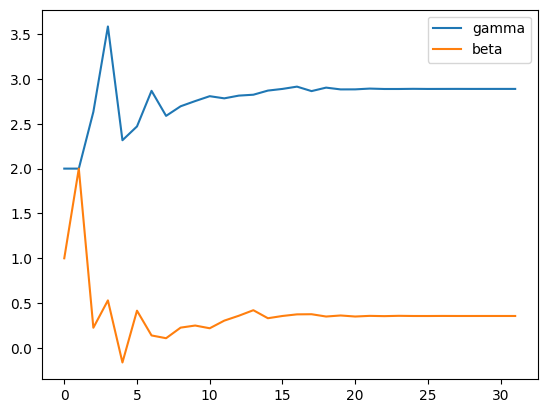

In [227]:
from scipy.optimize import minimize
expectation = quantum_circuit(graph)

alpha_optimization = []
beta_optimization = []



def progress(values):
    print ('progress', values)
    alpha_optimization.append(values[0])
    beta_optimization.append(values[1])

res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA', callback=progress)
print(res)

import matplotlib.pyplot as plt 

plt.plot(alpha_optimization, label="gamma")
plt.plot(beta_optimization, label='beta')
plt.legend()
plt.show()



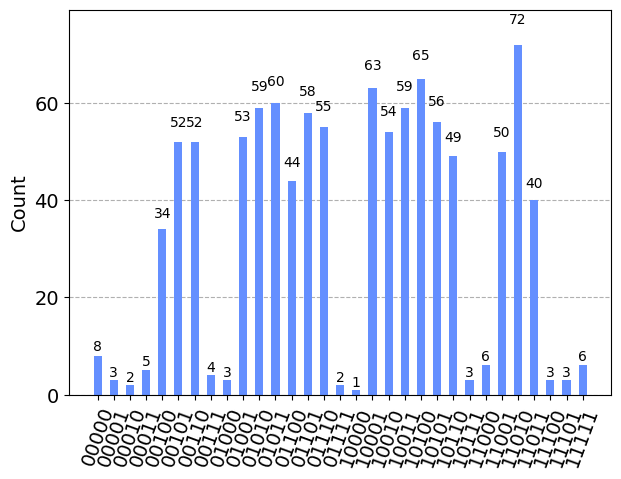

In [228]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 2000

from qiskit.visualization import plot_histogram
a = tqc.bind_parameters({beta: res.x[0], gamma: res.x[1]})
counts = backend.run(a, seed_simulator=10).result().get_counts()
plot_histogram(counts)


In [233]:
sorted_probs = sorted(counts.items(), key=lambda x: x[1])
for k,v in sorted_probs:
    value = -maxcut_obj(k, graph)
    if value == 4:
        print (k, 'prob:', v, maxcut)

sorted_probs[-1]


00100 prob: 34
11011 prob: 40
01100 prob: 44
10110 prob: 49
11001 prob: 50
00101 prob: 52
00110 prob: 52
01001 prob: 53
10010 prob: 54
01110 prob: 55
10101 prob: 56
01101 prob: 58
01010 prob: 59
10011 prob: 59
01011 prob: 60
10001 prob: 63
10100 prob: 65
11010 prob: 72


('11010', 72)

The following is the solution for the max cut butterfly graph. 

/Users/venkat/opt/anaconda3/envs/QCML/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


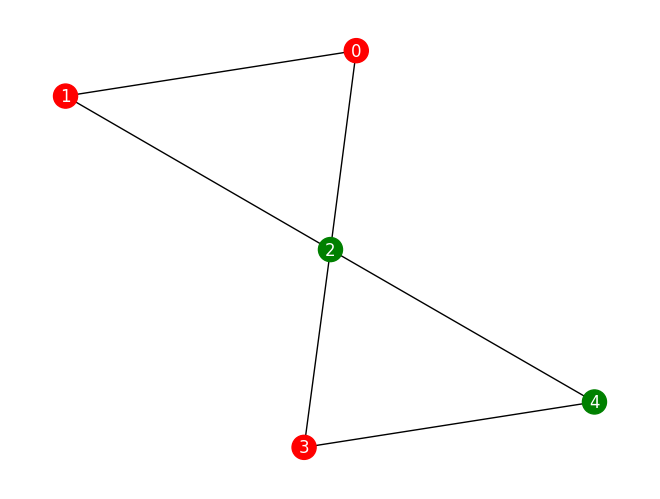

In [230]:
valuemap = {
    '0': 'green',
    '1':  'red'
}
values = [valuemap[sorted_probs[-1][0][node]] for node in graph.nodes()]
import matplotlib.pyplot as plt
nx.draw(graph, cmap=plt.get_cmap('viridis'), node_color=values, with_labels=True, font_color='white')
plt.show()

0101 and 1010 are the right solution. 